In [109]:
from keras import applications
import matplotlib.pyplot as plt

%matplotlib inline

import random
import time

random.seed(time.time())

In [35]:
# load trained vgg 16
pretrained_vgg_16 = applications.VGG16(weights='imagenet', include_top = True)

In [36]:
from keras.models import Model

# found with pretrained_vgg_16.layers[-2].get_config()
layer_name = 'fc2'

# get penultimate activation layer (relu activation layer)
intermediate_layer_model = Model(inputs = pretrained_vgg_16.input, outputs = pretrained_vgg_16.get_layer(layer_name).output)

In [37]:
import os

# create list of all the image paths to add to the database
folder = "/Users/l1nda/desktop/images/"
image_list = []

folder_list = os.listdir(folder)
for image_name in folder_list:
    image_path = os.path.join(folder, image_name)
    image_list.append(image_path)

In [38]:
import cv2

feature_list = []
images_database = []

# list comprehension to only get jpgs
image_list = [image_name for image_name in image_list if image_name.endswith("jpg") or image_name.endswith("jpeg") or image_name.endswith("JPG")]

for image in image_list:
    # read image
    image = cv2.imread(image)
    # convert from bgr to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # add image to image list
    images_database.append(image)
    # resize for VGG
    image = cv2.resize(image, (224, 224))
    
    # add dummy dimension
    image = image[None]
    # extract feature vec for each image
    feature_vec = intermediate_layer_model.predict(image)
    # concat vector to one big list
    feature_list.append(feature_vec.ravel())

In [39]:
# turn list into an array to run nearest neighbors on database

import numpy as np
np.array(feature_list).shape

(544, 4096)

In [40]:
from sklearn.neighbors import NearestNeighbors

# get the 3 nearest neighbors (as 0 is the image itself)
neighbors = NearestNeighbors(n_neighbors=4)

# "train data" (organizes NN data to make querying faster)
neighbors.fit(feature_list)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=4, p=2, radius=1.0)

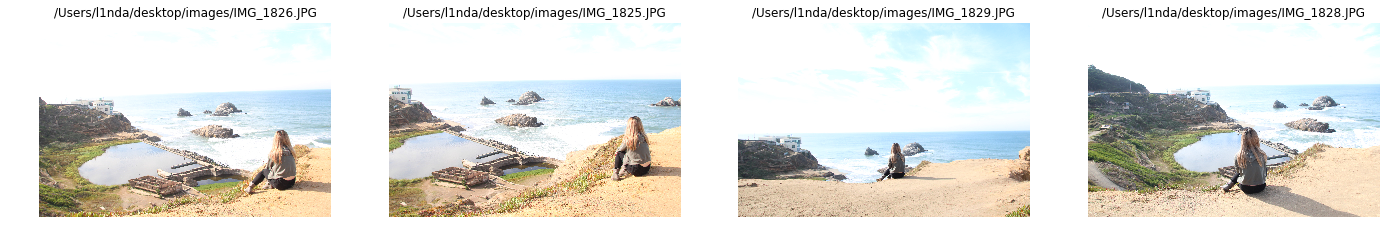

In [145]:
# create random number image to compare
image_wanted = random.randint(0, len(feature_list))

# query feature list for the image
query_vec = feature_list[image_wanted] 
distances, indices = neighbors.kneighbors(query_vec[None])

# plot the image itself and its three nearest neighbors
fig = plt.figure()
for i in range(4):
    plot = plt.subplot(1, 4, i+1)
    plt.imshow(images_database[indices[0][i]])
    plt.axis('off')
    plot.set_title(image_list[indices[0][i]])

# sets image size so that they fit horizontally in a row
fig.set_size_inches(np.array(fig.get_size_inches()) * 4)
plt.show()